In [1]:
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torchaudio
import numpy as npw
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, SequentialSampler
from sklearn.model_selection import train_test_split
from adasp_data_management import music

import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

eps = 1e-6

/home/ids/edabier/miniconda3/envs/amt-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
    torch.set_default_device(dev)
else:
    print(f"{torch.cuda.is_available()}")
    dev = "cpu"

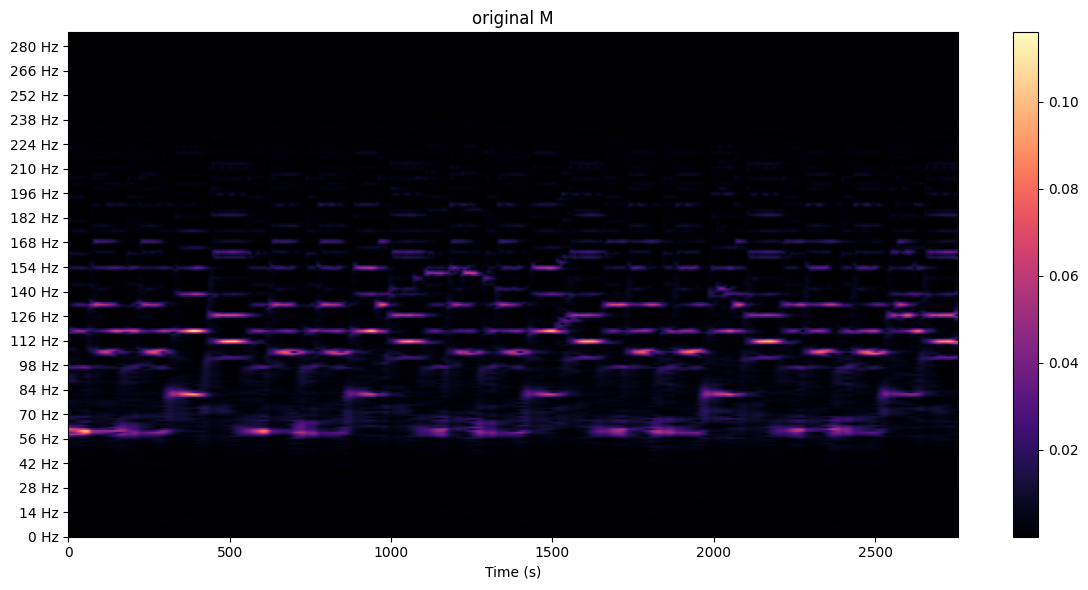

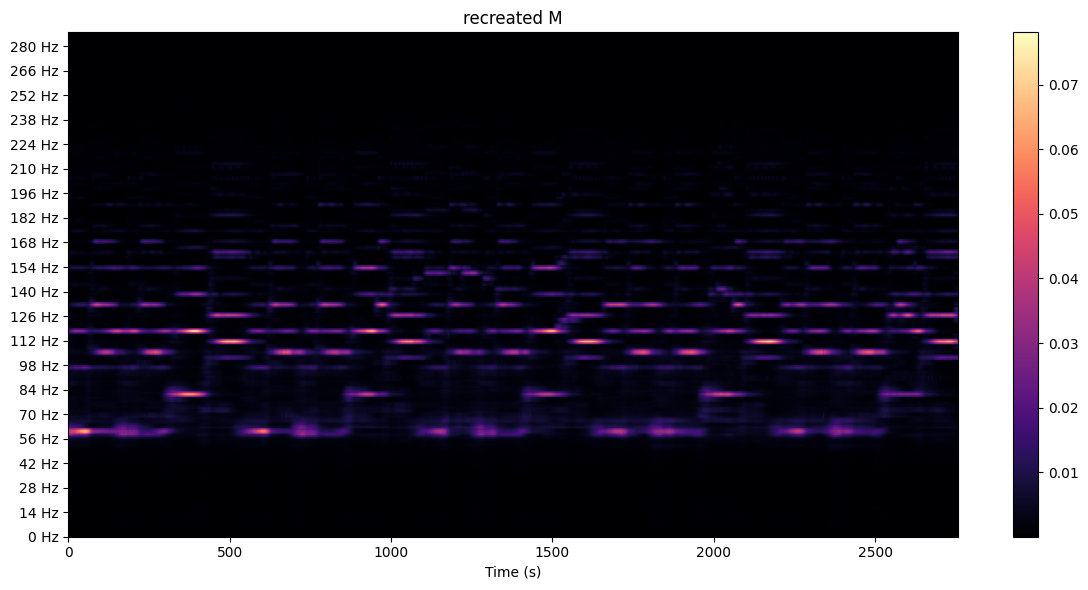

In [5]:
n_iter=10
shared=True
aw2d=False
clip=False
dtype = None
W_path = '/home/ids/edabier/AMT/Unrolled-NMF/test-data/synth-single-notes'

ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=n_iter, hidden=16, n_init_steps=1, shared=shared, return_layers=False, aw_2d=aw2d, clip_H=clip, dtype=dtype)
state_dict = torch.load('/home/ids/edabier/AMT/Unrolled-NMF/models/checkpoint.pt')
ralmu.load_state_dict(state_dict['model_state_dict'])

y, sr = torchaudio.load("test-data/piano-dataset/audios/example-7.wav")
M, times, freqs_M = spec.cqt_spec(y, sr, normalize_thresh=0.1)
single_note = 'test-data/synth-single-notes'
W, freqs, sample_rate, true_freqs = init.init_W(single_note, normalize_thresh=0.1)
H = init.init_H(W=W, M=M, n_init_steps=10, device=dev)
midi, onset, offset, _ = spec.midi_to_pianoroll(f"test-data/piano-dataset/midis/example-7.mid", y, times, hop_length=128, sr=sr)
midi = midi.to(dev)

ralmu.eval()
with torch.no_grad():
    W_hat, H_hat, M_hat = ralmu.forward(M, device=dev)
    M_hat = M_hat.detach()
    
spec.vis_cqt_spectrogram(M.cpu(), title="original M")
spec.vis_cqt_spectrogram(M_hat.cpu(), title="recreated M")
# spec.vis_cqt_spectrogram(M.cpu(), title="original M")
# spec.vis_cqt_spectrogram(M_hat.cpu(), title="recreated M")
# fig, axs = plt.subplots(2,3, figsize=(30,20))

# axs[0,0].imshow(M.cpu(), extent="auto", cmap="magma")
# axs[0,1].imshow(H.cpu(), extent="auto", cmap="magma")
# axs[0,2].imshow(W.cpu(), extent="auto", cmap="magma")
# axs[1,0].imshow(M_hat.cpu(), extent="auto", cmap="magma")
# axs[1,1].imshow(H_hat.cpu(), extent="auto", cmap="magma")
# axs[1,2].imshow(W_hat.cpu(), extent="auto", cmap="magma")

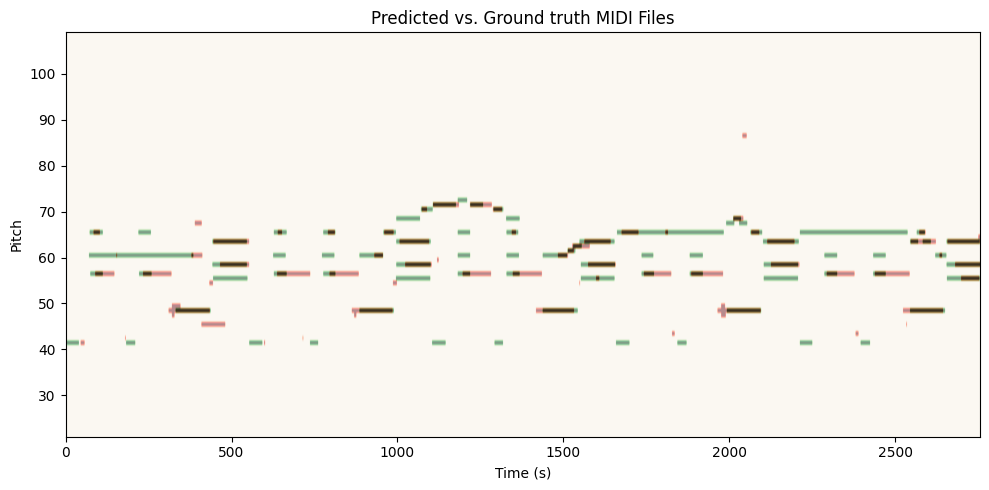

precision: 0.6363636363636364, recall: 0.7101449275362319, f_mesure: 0.6712328767123288, accuracy: 0.550561797752809


In [7]:
_, notes_hat = init.W_to_pitch(W_hat, true_freqs=None, use_max=True)
midi_hat, active_midi = init.WH_to_MIDI(W_hat, H_hat, notes_hat, normalize=False, threshold=0.1, smoothing_window=10, min_note_length=30, sr=sr)
spec.compare_midi(midi.cpu(), midi_hat.cpu())
prec, rec, f_mes, accuracy = utils.compute_metrics(midi, midi_hat, time_tolerance=100)
print(f"precision: {prec}, recall: {rec}, f_mesure: {f_mes}, accuracy: {accuracy}")

### Create MAPS metadata.csv

In [ ]:
base_dir = path

# Define the directories
m_dir = os.path.join(base_dir, 'M')
midi_dir = os.path.join(base_dir, 'H', 'midi')
onsets_dir = os.path.join(base_dir, 'H', 'onsets')
offsets_dir = os.path.join(base_dir, 'H', 'offsets')

# Get the list of files in the M directory
m_files = sorted(os.listdir(m_dir))

# Initialize a list to store the metadata
metadata = []
for m_file in m_files:
    # Extract the base name without extension
    base_name = os.path.splitext(m_file)[0]

    # Define the corresponding file paths
    file_path = os.path.join(m_dir, m_file)
    midi_path = os.path.join(midi_dir, f"{base_name}.pt")
    onset_path = os.path.join(onsets_dir, f"{base_name}.pt")
    offset_path = os.path.join(offsets_dir, f"{base_name}.pt")

    # Add the file paths to the metadata list
    metadata.append({
        "file_path": file_path,
        "midi_path": midi_path,
        "onset_path": onset_path,
        "offset_path": offset_path
    })

# Create a DataFrame from the metadata list
metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv(f'{path}/metadata.csv', index=False)

NotADirectoryError: [Errno 20] Not a directory: '/home/ids/edabier/AMT/Unrolled-NMF/MAPS/metadata.csv/M'

### Load the ground truth dataset

In [ ]:
maps = music.Maps("/tsi/mir/maps")
metadata = maps.pdf_metadata

train_size = 0.8
train_data, test_data   = train_test_split(metadata, train_size=train_size, random_state=1)
train_data, valid_data  = train_test_split(train_data, train_size=train_size, random_state=1)

subset = 1
length = None
sort = True
filt = True
dtype = torch.float16

train_set   = utils.MapsDataset(train_data, fixed_length=length, subset=subset, verbose=True, sort=sort, filter=filt, dtype=dtype)
test_set    = utils.MapsDataset(test_data, fixed_length=length, subset=subset, verbose=True, sort=sort, filter=filt, dtype=dtype)
valid_set   = utils.MapsDataset(valid_data, fixed_length=length, subset=subset, verbose=True, sort=sort, filter=filt, dtype=dtype)

batch_size      = 4
train_sampler   = utils.SequentialBatchSampler(train_set, batch_size=batch_size)
train_loader    = DataLoader(train_set, batch_sampler=train_sampler, collate_fn=utils.collate_fn)

test_sampler   = utils.SequentialBatchSampler(test_set, batch_size=batch_size)
test_loader     = DataLoader(test_set, batch_sampler=test_sampler, collate_fn=utils.collate_fn)

valid_sampler   = utils.SequentialBatchSampler(valid_set, batch_size=batch_size)
valid_loader    = DataLoader(valid_set, batch_sampler=valid_sampler, collate_fn=utils.collate_fn)

Maps: load metadata file /tsi/mir/maps/metadata.csv
Computing the length of files...


1111it [02:12,  6.68it/s]

### Create the model
`hidden`=`8`, `shared`=`True` => 1122 params

In [ ]:
W_path = 'test-data/synth-single-notes'
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=10, n_init_steps=1, hidden=8, shared=True, return_layers=False, batch_size=batch_size, smaller_A=True, dtype=dtype)
utils.model_infos(ralmu, names=False)
ralmu

The model has 1122 parameters


RALMU(
  (layers): ModuleList(
    (0-9): 10 x RALMU_block(
      (Aw): Aw_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01)
        (softplus): Softplus(beta=1.0, threshold=20.0)
      )
      (Ah): Ah_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.